In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from mytools.utils import get_mask_sector, get_mask_square, get_coord
from crafts_stack.halo_models import get_submodel_contributions, get_default_model
from crafts_stack.halo_fitting import halofit
from mytools.plot import plot_heatmap,save_plot, plot_heatmaps, make_figure, plot_sector, plt
from mytools.plot_custom import plot_stack_fit_res, compare_profiles
%matplotlib inline

# Halo contribution fitting

## stacked result

<Axes: title={'center': 'Masked stack result'}, xlabel='X', ylabel='Y'>

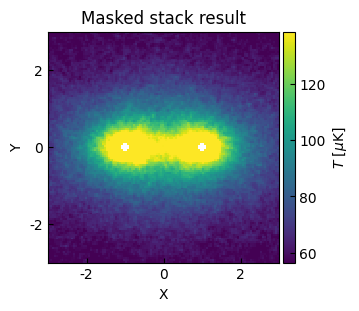

In [3]:
stack_result = np.load("tngcube_pairstack_result.npz")["data"]

halo_peak_mask = get_mask_sector(rlim=[0.0, 0.1], thetalim=[-np.pi / 2, np.pi / 2])
stack_result_masked = np.ma.array(stack_result, mask=halo_peak_mask, fill_value=0)

plot_heatmap(stack_result_masked, title="Masked stack result", cmap="viridis")

## sector mask

<Axes: title={'center': 'Fitting mask'}, xlabel='X', ylabel='Y'>

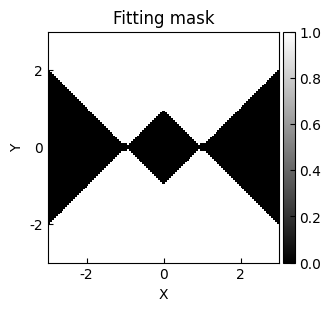

In [4]:
fit_mask = get_mask_sector(rlim=[0.1, 5])
plot_heatmap(fit_mask, title="Fitting mask", cmap="gray", cbar_label="")

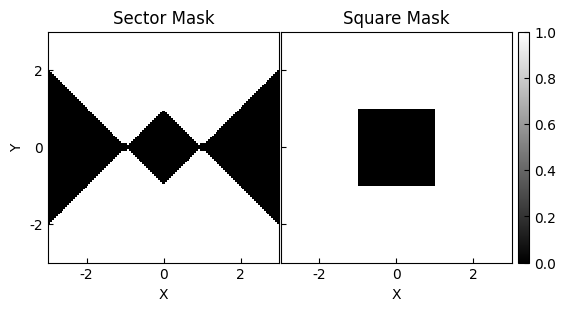

In [5]:
fmask_sector = get_mask_sector([0.1,5])
fmask_square = ~get_mask_square()

fig, axes = make_figure(1,2,figsize=(6,3), wspace=0.)
plot_heatmaps([fmask_sector,fmask_square], title=['Sector Mask', 'Square Mask'], cmap='gray', cbar_label='', show_cbar=[False, True], axes=axes)
fname = 'img_fitting_mask_compare.png'
# save_plot(fig, fname)

## analytical model

In [6]:
coord = get_coord()
model = get_default_model()

Model: CompoundModel
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4]
Components: 
    [0]: <NFW2D(amplitude=50., x_mean=-1., y_mean=0., r_s=0.5)>

    [1]: <NFW2D(amplitude=50., x_mean=1., y_mean=0., r_s=0.5)>

    [2]: <Gaussian2D(amplitude=50., x_mean=-1., y_mean=0., x_stddev=0.5, y_stddev=0.5, theta=0.)>

    [3]: <Gaussian2D(amplitude=50., x_mean=1., y_mean=0., x_stddev=0.5, y_stddev=0.5, theta=0.)>

    [4]: <Const2D(amplitude=0.)>
Parameters:
    amplitude_0 x_mean_0 y_mean_0 r_s_0 ... y_stddev_3 theta_3 amplitude_4
    ----------- -------- -------- ----- ... ---------- ------- -----------
           50.0     -1.0      0.0   0.5 ...        0.5     0.0         0.0
Fixed parameters are: ['x_mean_0', 'y_mean_0', 'x_mean_1', 'y_mean_1', 'x_mean_2', 'y_mean_2', 'theta_2', 'x_mean_3', 'y_mean_3', 'theta_3']
Tied parameters are: ['amplitude_0', 'amplitude_2', 'x_stddev_2', 'x_stddev_3']
Paramters bounds are: [['amplitude_0', (0.0, None)], ['r

## analytical fitting

In [7]:
result_list, fitted_model, fit_info = halofit(
    coord, stack_result_masked, model=model, print_model=True, mask=fit_mask
)


Fitted model:
Model: CompoundModel
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4]
Components: 
    [0]: <NFW2D(amplitude=0.58514, x_mean=-1., y_mean=0., r_s=34.26721126)>

    [1]: <NFW2D(amplitude=0.58514, x_mean=1., y_mean=0., r_s=33.82234556)>

    [2]: <Gaussian2D(amplitude=35.22117474, x_mean=-1., y_mean=0., x_stddev=0.84801558, y_stddev=0.84801558, theta=0.)>

    [3]: <Gaussian2D(amplitude=35.22117474, x_mean=1., y_mean=0., x_stddev=0.85409882, y_stddev=0.85409882, theta=0.)>

    [4]: <Const2D(amplitude=48.3818221)>
Parameters:
       amplitude_0     x_mean_0 y_mean_0 ... theta_3    amplitude_4    
    ------------------ -------- -------- ... ------- ------------------
    0.5851400014855158     -1.0      0.0 ...     0.0 48.381822101385275

Goodness of fit:
Chi-squared: 84484.619
Reduced chi-squared: 8.181
RMS residual: 2.857



Plot saved to img_tngcube_halofitting_analytical_stack_fit_res.png


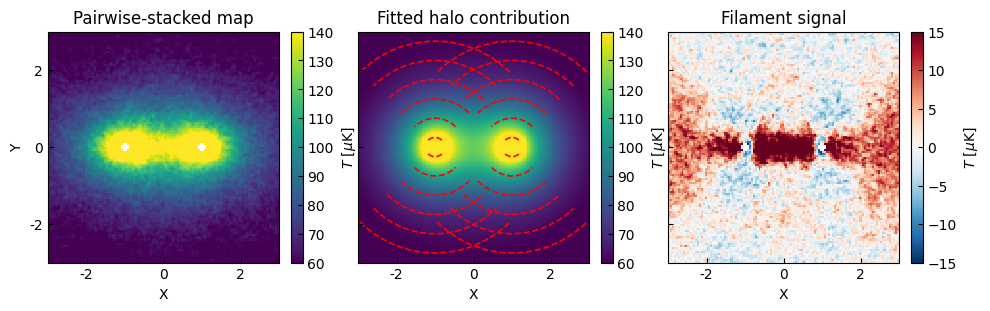

In [8]:
axes = plot_stack_fit_res(
    result_list,  # pyright: ignore[reportArgumentType]
    norm="linear",
    cmap=["viridis", "viridis", "RdBu_r"],
    vmax=[140, 140, 15],
    vmin=[60, 60, -15],
)
plot_sector(axes[1], ec='r')
fname = "img_tngcube_halofitting_analytical_stack_fit_res.png"
save_plot(axes, fname)

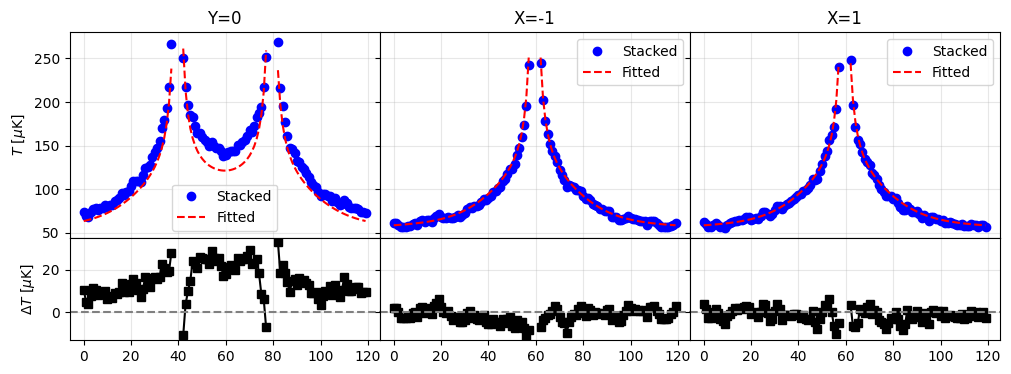

In [9]:
_, fitted, residual = result_list
fitted = np.ma.array(fitted, mask=halo_peak_mask)
compare_profiles([stack_result_masked, fitted]);

<Axes: title={'center': 'Normalized Residual'}, xlabel='X', ylabel='Y'>

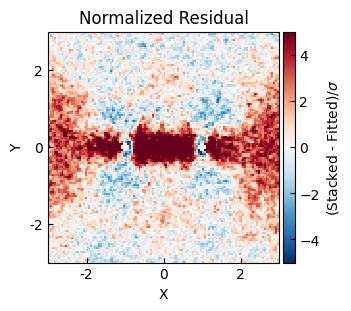

In [10]:
plot_heatmap(
    residual / 2.5,
    title="Normalized Residual",
    cmap="RdBu_r",
    cbar_label=r"(Stacked - Fitted)/$\sigma$",
    vmax=5,
    vmin=-5,
)

# covariance matrix


Fitted parameters with errors:
  r_s_0: 34.2672 +/- 26.8941
  amplitude_1: 0.5851 +/- 0.4603
  r_s_1: 33.8223 +/- 26.5422
  y_stddev_2: 0.8480 +/- 0.0052
  amplitude_3: 35.2212 +/- 0.2812
  y_stddev_3: 0.8541 +/- 0.0053
  amplitude_4: 48.3818 +/- 1.3733


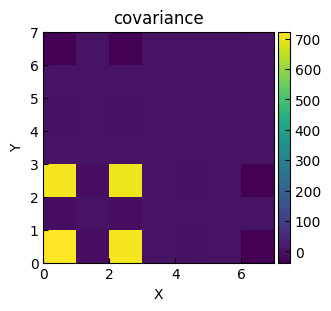

In [11]:
from crafts_stack.halo_fitting import get_free_params, print_param_error

cov = fit_info['param_cov']
plot_heatmap(cov, change_ticks=False, q=None, cbar_label='', title='covariance')

free_params_names, free_params_values = get_free_params(fitted_model)
print_param_error(fitted_model, fit_info)

# Estimate filament signal level

In [12]:
from mytools.estimate import get_signal_level
from mytools.plot_custom import plot_profile_2c

Parameter names:
('amplitude_0', 'mean_0', 'stddev_0', 'amplitude_1')
Gauss fit parameters: [np.float64(22.801275976300065), np.float64(0.0), np.float64(0.2704539425771884), np.float64(0.5093707570734654)]
Gauss fit covariance (without fix mean): 
[[ 2.09192987e-01 -1.43265000e-03 -9.90601248e-03]
 [-1.43265000e-03  4.18702494e-05 -2.34997386e-04]
 [-9.90601248e-03 -2.34997386e-04  1.40092172e-02]]
0 points clipped during sigma clipping.

Goodness of fit:
Chi-squared: 149.939
Reduced chi-squared: 1.282
RMS residual: 1.118

width: 0.2704539425771884
width_pix: 5


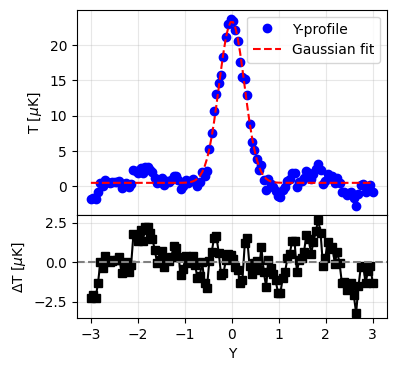

In [13]:
bounds = {
    "amplitude_0": (0, np.inf),  # amplitude
    "stddev_0": (0, 0.6),  # sigma
}

lx, ly, clrb, params, cov = get_signal_level(residual, bounds=bounds, show_fit=True, print_info=True)

Plot saved to img_tngcube_halofitting_analytical_signal.png


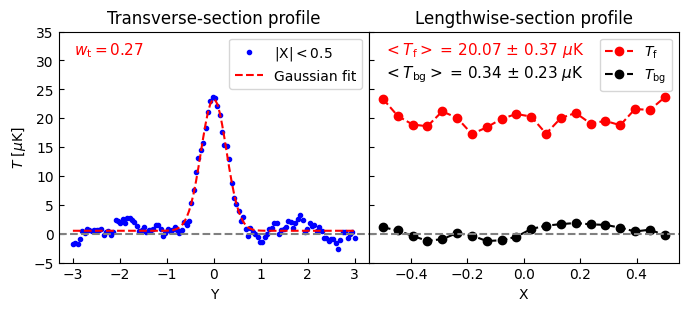

In [14]:
# text_pos = [[-0.35, 12], [-0.38, 4], [-2.5, 12]]
axes = plot_profile_2c(lx, ly, width=params[2], fontsize=11, text_pos=None)
axes[0].set_ylim(-5, 35)

fname = 'img_tngcube_halofitting_analytical_signal.png'
save_plot(axes, fname)

# Check submodel contributions

Constant contribution: 48.38 $\mu$K


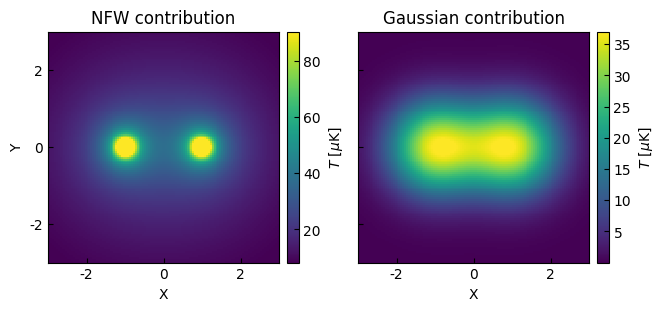

In [15]:
submodel_contris = get_submodel_contributions(fitted_model, *coord)
contris_nfw = submodel_contris[0] + submodel_contris[1]
contris_gaussian = submodel_contris[2] + submodel_contris[3]
contris_bg = submodel_contris[4]

axes = plot_heatmaps([contris_nfw, contris_gaussian], title=["NFW contribution","Gaussian contribution"], cmap="viridis", q=1)
print(r'Constant contribution: %.2f $\mu$K'%contris_bg.mean())

Plot saved to img_tngcube_halofitting_analytical_contribution_check.png


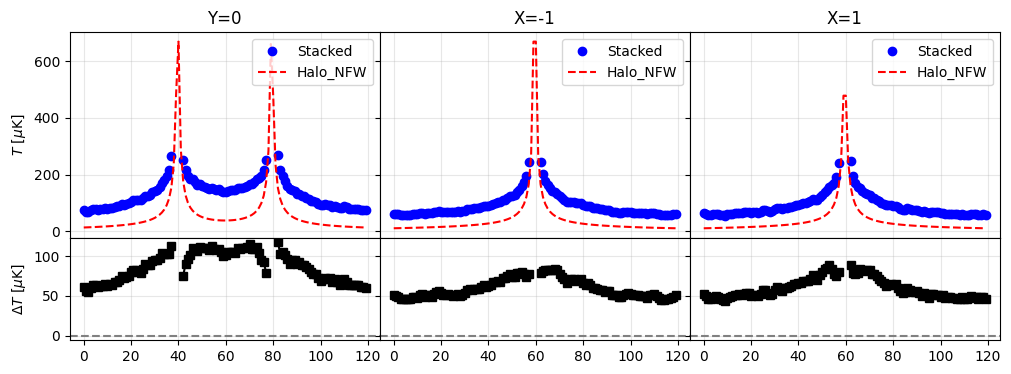

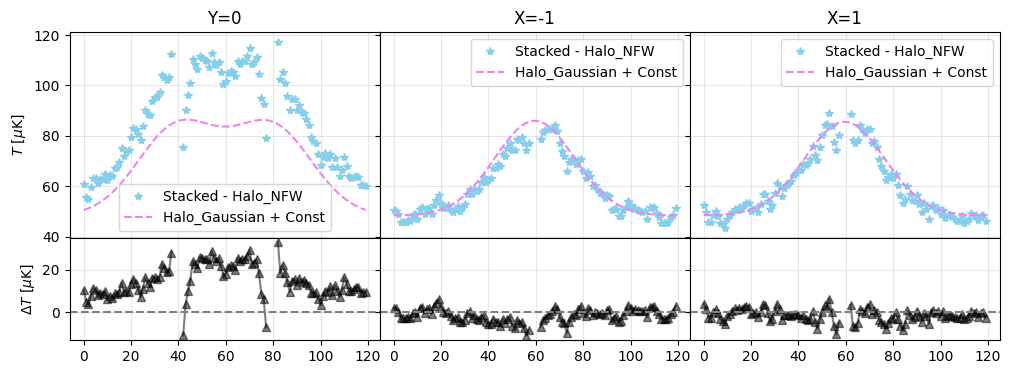

In [16]:
_axes1 = compare_profiles(
    [stack_result_masked, contris_nfw], 
    labels=['Stacked', 'Halo_NFW'],
)


_axes2 = compare_profiles(
    [stack_result_masked - contris_nfw, contris_gaussian + contris_bg], 
    labels=['Stacked - Halo_NFW', 'Halo_Gaussian + Const'],
    kw_line1=dict(color='skyblue',marker='*'),
    kw_line2=dict(color='violet',marker=' '),
    kw_diff=dict(color='k', marker='^', alpha=0.5)
)

save_plot(_axes2,'img_tngcube_halofitting_analytical_contribution_check.png')